<a href="https://colab.research.google.com/github/kimdahyeon977/plant_pathology/blob/main/classification-active.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install pytorch-lightning -q
! pip list | grep torch
! nvidia-smi

     |████████████████████████████████| 585 kB 4.7 MB/s 
     |████████████████████████████████| 596 kB 48.4 MB/s 
     |████████████████████████████████| 140 kB 61.6 MB/s 
     |████████████████████████████████| 419 kB 53.4 MB/s 
     |████████████████████████████████| 1.1 MB 55.4 MB/s 
     |████████████████████████████████| 271 kB 77.8 MB/s 
     |████████████████████████████████| 144 kB 63.7 MB/s 
     |████████████████████████████████| 94 kB 4.7 MB/s 
pytorch-lightning             1.6.5
torch                         1.12.0+cu113
torchaudio                    0.12.0+cu113
torchmetrics                  0.9.2
torchsummary                  1.5.1
torchtext                     0.13.0
torchvision                   0.13.0+cu113
Sat Jul 16 11:01:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+-----------------

In [2]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

#코랩 구글마운트 인증키 넣어서 해결해보기

# Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME ='엘리스_AI프로젝트 '
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/Shareddrives/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd drive/Shareddrives/$FOLDERNAME

Mounted at /content/drive
[Errno 2] No such file or directory: 'drive/Shareddrives/엘리스_AI프로젝트'
/content


In [3]:
%cd drive/Shareddrives/'엘리스_AI프로젝트 '

/content/drive/Shareddrives/엘리스_AI프로젝트 


In [4]:
import random
import torch
def seed_everything(seed=7):
    random.seed(seed)
    os.environ['PYTHONHASHSEED']= str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False

In [5]:
%matplotlib inline
import numpy as np
import os
import json
import pandas as pd
from pprint import pprint

base_path = ''
path_csv =  'data.csv'
data=pd.read_csv(path_csv)

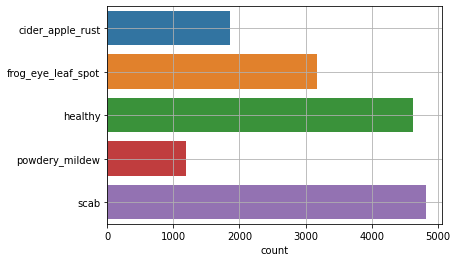

In [6]:
import itertools
import seaborn as sns

labels_all = list(data['labels'])
ax = sns.countplot(y=sorted(labels_all), orient='v')
ax.grid()

In [7]:
print(data['labels'].value_counts())

scab                  4826
healthy               4624
frog_eye_leaf_spot    3181
cider_apple_rust      1860
powdery_mildew        1184
Name: labels, dtype: int64


**< imbalance data를 해결하는 방법 >**

1. oversampling 
장점 : under-sampling보다 성능이 뛰어나다. 
단점 : minor class를 판별시 과적합 될 가능성이 있다.

2. undersampling
장점 :  모델이 빨리 돌아간다.
단점 : 과적합

3. SMOTE : 주변에 있는 데이터셋의 특징과 유사하게 데이터를 생성한다.
장점 : 데이터 손실을 하지 않으면서 과적합을 피할 수 있다.
단점 : 고차원 데이터에 효율적이지 않다.

우리는 고차원 데이터를 다루고 있기때문에 oversampling을 쓸 것이다.

**< Pytorch 에서는 어떻게 ? >** 

파이토치에서 sampler 옵션을 사용하면 데이터 크래스와 상호 작용하고 이 클래스에서 샘플링 하는 방법을 알려준다.
다른 클래스의 가중치를 사용하여 sampler 클래스 객체를 생성하는 방식이다.

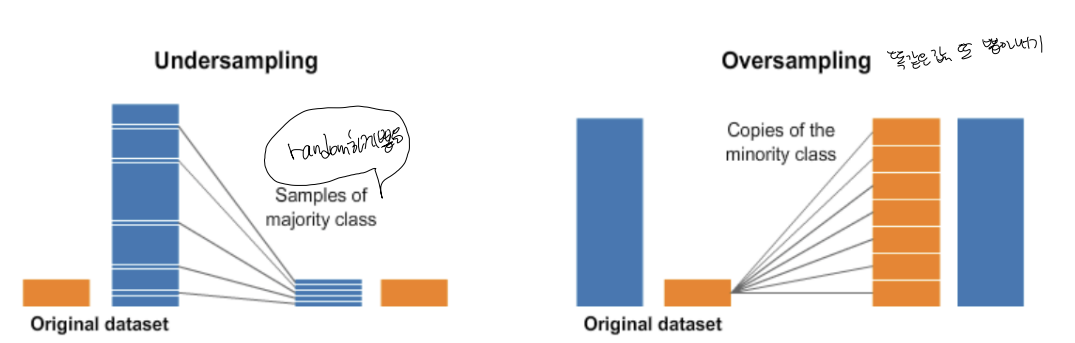

**< 주의할 점! >**

반드시 cross-validation을 한 후에 데이터를 증강시킨다.
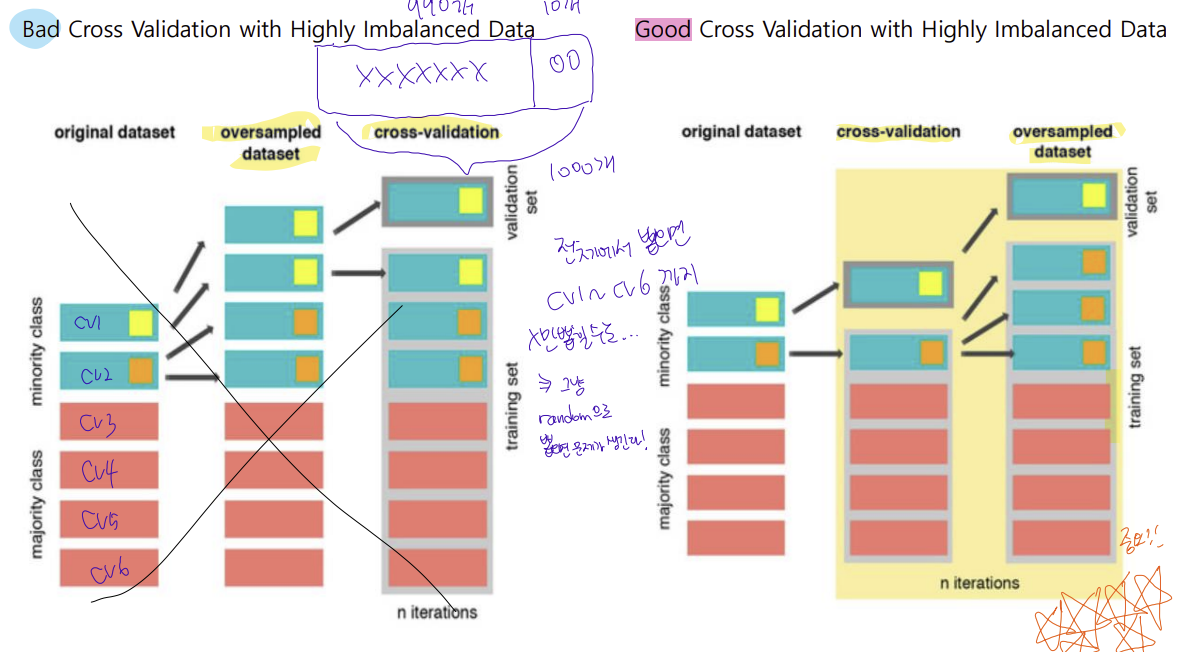

In [ ]:
# labels_unique = set(labels_all)
# print(f"unique labels: {labels_unique}")
# train_data['labels_sorted'] = [" ".join(sorted(lbs.split(" "))) for lbs in train_data['labels']]

# labels_combine = {}
# for comb in train_data['labels_sorted']:
#     labels_combine[comb] = labels_combine.get(comb, 0) + 1

# show_counts = '\n'.join(sorted(f'\t{k}: {v}' for k, v in labels_combine.items()))
# print(f"unique combinations: \n" + show_counts)
# print(f"total: {sum(labels_combine.values())}")

(-0.5, 959.5, 640.5, -0.5)

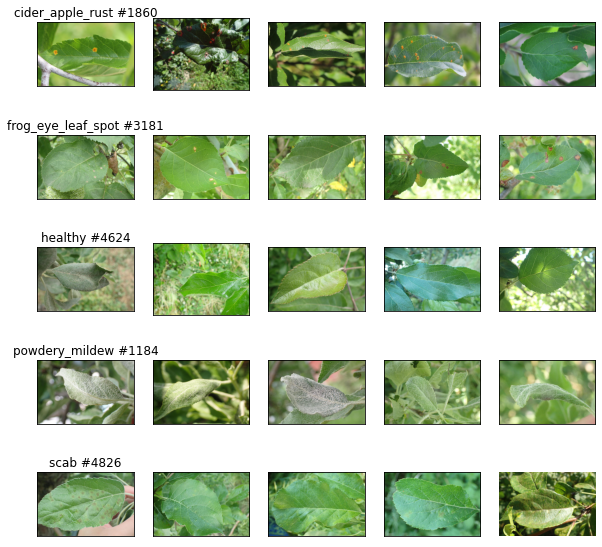

In [7]:
import matplotlib.pyplot as plt

nb_samples = 5
n, m = len(np.unique(data['labels'])), nb_samples,
fig, axarr = plt.subplots(nrows=n, ncols=m, figsize=(m * 2, n * 2))
for ilb, (lb, df_) in enumerate(data.groupby('labels')):
    img_names = list(df_['image'])
    for i in range(m):
        img_name = img_names[i]
        img = plt.imread(os.path.join(base_path, f"train_images/{img_name}"))
        axarr[ilb, i].imshow(img)
        if i == 0:
            axarr[ilb, i].set_title(f"{lb} #{len(df_)}")
        axarr[ilb, i].set_xticks([])
        axarr[ilb, i].set_yticks([])
plt.axis('off')

In [ ]:
def edge_and_cut(img):
    emb_img = img.copy()
    edges = cv2.Canny(img, 100, 200)
    edge_coors = []
    for i in range(edges.shape[0]):
        for j in range(edges.shape[1]):
            if edges[i][j] != 0:
                edge_coors.append((i, j))
    
    row_min = edge_coors[np.argsort([coor[0] for coor in edge_coors])[0]][0]
    row_max = edge_coors[np.argsort([coor[0] for coor in edge_coors])[-1]][0]
    col_min = edge_coors[np.argsort([coor[1] for coor in edge_coors])[0]][1]
    col_max = edge_coors[np.argsort([coor[1] for coor in edge_coors])[-1]][1]
    new_img = img[row_min:row_max, col_min:col_max]
    
    emb_img[row_min-10:row_min+10, col_min:col_max] = [255, 0, 0]
    emb_img[row_max-10:row_max+10, col_min:col_max] = [255, 0, 0]
    emb_img[row_min:row_max, col_min-10:col_min+10] = [255, 0, 0]
    emb_img[row_min:row_max, col_max-10:col_max+10] = [255, 0, 0]
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 20))
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Original Image', fontsize=24)
    ax[1].imshow(new_img, cmap='gray')
    ax[1].set_title('Canny Edges', fontsize=24)
    ax[2].imshow(emb_img, cmap='gray')
    ax[2].set_title('Bounding Box', fontsize=24)
    plt.show()

데이터셋 준비!

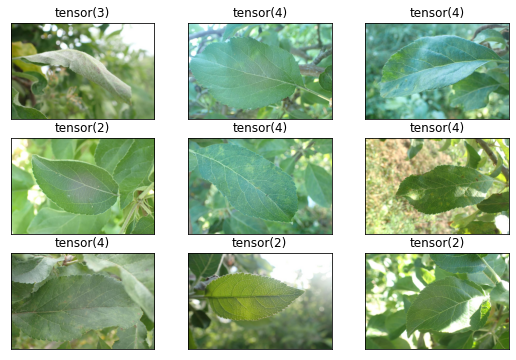

In [27]:
from sklearn.model_selection import StratifiedKFold
n_iter=0
skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(data['image'], data['labels']):
            n_iter+=1
import os
import torch
from PIL import Image
from torch.utils.data import Dataset

class PlantPathologyDataset(Dataset):
    def __init__(
        self,
        path_csv: str= 'data.csv',
        path_img_dir: str = os.path.join(base_path, 'train_images'),
        transforms = None,
        mode: str = 'train',
        split: float = 0.8,
    ):
        self.path_img_dir = path_img_dir
        self.transforms = transforms
        self.mode = mode

        self.data = pd.read_csv(path_csv)
        labels_all = list(itertools.chain(*[lbs.split(" ") for lbs in self.data['labels']]))
        self.labels_unique = sorted(set(labels_all))
        self.labels_lut = {lb: i for i, lb in enumerate(self.labels_unique)}
        self.num_classes = len(self.labels_unique)

        # split dataset
        self.data = self.data.sample(frac=1).reset_index(drop=True)
        if mode == 'train':
            self.data=self.data.iloc[train_index]
            self.unlabeled_mask=np.zeros(len(self.data))
        else:
            self.data=self.data.iloc[test_index]
            self.unlabeled_mask=np.ones(len(self.data))
        #self.data = self.data.iloc[train_index] if mode == 'train' else self.data.iloc[test_index]
        self.img_names = list(self.data['image'])
        self.labels = list(self.data['labels'])

    def to_one_hot(self, labels: str) -> tuple:
        one_hot = [0] * len(self.labels_unique)
        for lb in labels.split(" "):
            one_hot[self.labels_lut[lb]] = 1
        return tuple(one_hot)

    def __getitem__(self, idx: int) -> tuple:
        img_path = os.path.join(self.path_img_dir, self.img_names[idx])
        assert os.path.isfile(img_path)
        label = self.labels[idx]
        img = plt.imread(img_path)

        # augmentation
        if self.transforms:
            img = self.transforms(Image.fromarray(img))
        label = self.to_one_hot(label)
        label=np.argmax(label).reshape(-1,1)
        return img, torch.tensor(label[0][0]),idx

    def __len__(self) -> int:
        return len(self.data)
    def undate_label(self,idx,new_label):
        self.labels[idx]=new_label
        self.unlabeled_mask[idx]=0
        return
    def label_from_filename(self,idx):
        self.labels[idx]=self.labels[idx]
        self.unlabeled_mask[idx]=0
        return

# ==============================
# ==============================

dataset = PlantPathologyDataset()

# quick view
fig = plt.figure(figsize=(9, 6))
for i in range(9):
    img, lb,_ = dataset[i]
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    ax.imshow(img)
    ax.set_title(lb)

In [9]:
train_data = data.iloc[train_index,]
test_data=data.iloc[test_index,]

In [10]:
from torchvision import transforms as T
TRAIN_TRANSFORM = T.Compose([
    T.Resize(512),
    T.RandomPerspective(),
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    # T.Normalize([0.431, 0.498,  0.313], [0.237, 0.239, 0.227]),  # custom
])

VALID_TRANSFORM = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    # T.Normalize([0.431, 0.498,  0.313], [0.237, 0.239, 0.227]),  # custom
])

In [17]:
!pip install --upgrade wandb[service]
!pip install torch pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pytorch_lightning-1.6.5-py3-none-any.whl (585 kB)


training dataset: 12540
test dataset: 3135
5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch labels: 299
image size: torch.Size([3, 224, 224])
<class 'torch.Tensor'>


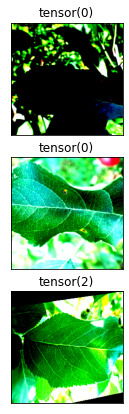

In [28]:
import multiprocessing as mproc
import pytorch_lightning as pl
from torch.utils.data import DataLoader

class PlantPathologyDM(pl.LightningDataModule):
    dataset_cls = PlantPathologyDataset

    def __init__(
        self,
        path_csv: str = 'data.csv',
        path_img_dir: str = os.path.join(base_path, 'train_images'),
        batch_size: int = 128,
        num_workers: int = None,
    ):
        super().__init__()
        self.path_csv = path_csv
        self.path_img_dir = path_img_dir
        self.batch_size = batch_size
        self.num_workers = num_workers if num_workers is not None else mproc.cpu_count()
        self.train_dataset = None
        self.test_dataset = None

    def prepare_data(self):
        pass

    @property
    def num_classes(self) -> int:
        assert self.train_dataset and self.test_dataset
        return max(self.train_dataset.num_classes, self.test_dataset.num_classes)

    def setup(self, stage=None):
        self.train_dataset = self.dataset_cls(self.path_csv, self.path_img_dir, mode='train', transforms=TRAIN_TRANSFORM)
        print(f"training dataset: {len(self.train_dataset)}")
        self.test_dataset = self.dataset_cls(self.path_csv, self.path_img_dir, mode='test', transforms=VALID_TRANSFORM)
        print(f"test dataset: {len(self.test_dataset)}")

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
        )


    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
        )

# ==============================
# ==============================

dm = PlantPathologyDM()
dm.setup()
print(dm.num_classes)

# quick view
fig = plt.figure(figsize=(3, 7))
for imgs, lbs,_ in dm.train_dataloader():
    print(f'batch labels: {torch.sum(lbs, axis=0)}')
    print(f'image size: {imgs[0].shape}')
    print(type(imgs))
    for i in range(3):
        ax = fig.add_subplot(3, 1, i + 1, xticks=[], yticks=[])
        # print(np.rollaxis(imgs[i].numpy(), 0, 3).shape)
        ax.imshow(np.rollaxis(imgs[i].numpy(), 0, 3))
        ax.set_title(lbs[i])
    break

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)
#print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Count of using GPUs: 1


##CNN Model

In [31]:
def create_model(pretrained=True):
    model = torchvision.models.resnet50(pretrained=pretrained).to(device)
    
    for param in model.layer1.parameters():
        param.requires_grad = False
        
    for param in model.layer2.parameters():
        param.requires_grad = False  
        
    for param in model.layer3.parameters():
        param.requires_grad = False 
    
    model.fc = torch.nn.Sequential(
        torch.nn.Linear(
            in_features=model.fc.in_features,
            out_features=5
        ),
        torch.nn.Sigmoid()
    ).to(device)
    
    return model


In [32]:
num_epochs=10
def train_epoch(model,device,dataloader,optimizer,loss_fn):
    train_loss,train_correct=0.0,0
    model.train()
    for images, labels in dataloader:
        
        images,labels = images.to(device),labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output,labels )
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()
    return train_loss,train_correct
  
def valid_epoch(model,device,dataloader,loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    for images, labels in dataloader:

        images,labels = images.to(device),labels.to(device)
        output = model(images)
        loss=loss_fn(output,labels)
        valid_loss+=loss.item()*images.size(0)
        scores, predictions = torch.max(output.data,1)
        val_correct+=(predictions == labels).sum().item()

    return valid_loss,val_correct

In [ ]:
pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import wandb

In [ ]:
import torch.nn as nn
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        BCE_loss = nn.CrossEntropyLoss()(inputs, targets)

        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
              return torch.mean(F_loss)
        else:
              return F_loss

In [ ]:
import torchvision
import tensorflow as tf
foldperf={}
from torch.utils.data import SubsetRandomSampler
# nSamples = [1860,3181,4624,1184,4826]
# normedWeights = [1 - (x / sum(nSamples)) for x in nSamples]
# normedWeights = torch.FloatTensor(normedWeights).to(device)
criterion = FocalLoss()
model = create_model(pretrained=True).to(device)
wandb.init(project='early stopping',entity='dahyeon')
wandb.watch(model,criterion,log="all",log_freq=10)
# early_stopping
last_loss = 100
patience = 2
trigger_times = 0
for fold, (train_idx,val_idx) in enumerate(skf.split(train_data['image'], train_data['labels'])):

    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(PlantPathologyDataset(mode='train', transforms=TRAIN_TRANSFORM), batch_size=64,sampler=train_sampler)
    test_loader = DataLoader(PlantPathologyDataset(mode='train', transforms=VALID_TRANSFORM), batch_size=64,sampler=test_sampler)
    
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005)

    history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}
    for epoch in range(num_epochs):
        train_loss, train_correct=train_epoch(model,device,train_loader,optimizer,criterion)
        test_loss, test_correct=valid_epoch(model,device,test_loader,criterion)
        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_correct / len(train_loader.sampler) * 100
        test_loss = test_loss / len(test_loader.sampler)
        test_acc = test_correct / len(test_loader.sampler) * 100
        if test_loss > last_loss:
            trigger_times += 1
            print('Trigger Times:', trigger_times)

            if trigger_times >= patience:
                print('Early stopping!\nStart to test process.')
                model = create_model(pretrained=True).to(device)
                model.load_state_dict(torch.load('best_model.pt'))

        else:
            print('trigger times: 0')
            trigger_times =0
            torch.save(model.state_dict(), 'best_model.pt')
            last_loss =test_loss
        print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(epoch + 1,
                                                                                                             num_epochs,
                                                                                                             train_loss,
                                                                                                             test_loss,
                                                                                                             train_acc,
                                                                                                             test_acc))
        wandb.log({'Epoch':epoch, 'train':{"acc":train_acc,"loss":train_loss},'val':{"acc":test_acc,"loss":test_loss}})
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)
        
    foldperf['fold{}'.format(fold+1)] = history  

torch.save(model,'k_cross_CNN_version2.pt')   

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Fold 1


KeyboardInterrupt: ignored

Error in atexit._run_exitfuncs:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/wandb_run.py", line 1876, in _atexit_cleanup
    self._on_finish()
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/wandb_run.py", line 1994, in _on_finish
    self._backend.interface.communicate_poll_exit()
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/interface/interface.py", line 653, in communicate_poll_exit
    resp = self._communicate_poll_exit(poll_exit)
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/interface/interface_shared.py", line 419, in _communicate_poll_exit
    result = self._communicate(rec)
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/interface/interface_shared.py", line 226, in _communicate
    return self._communicate_async(rec, local=local).get(timeout=timeout)
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/interface/interface_shared.py", line 231, in _communicate_async
    raise Exception("T

# labels_all=list(itertools.chain(*[lbs.split(" ") for lbs in data['labels']]))
labels_unique = sorted(set(labels_all))
labels_lut = {lb: i for i, lb in enumerate(labels_unique)}
num_classes = len(labels_unique)
categories=[k for k,v in labels_lut.items()]
labels_lut

In [33]:
import torchvision
model2 = create_model(pretrained=True).to(device)
model2.load_state_dict(torch.load('best_model (2).pt'))
#torch.save(model2,'k_cross_CNN_focalloss.pt')   
model2.eval()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [34]:
def count_frequency(my_list):
    
    count = {}
    
    for item in my_list:
        count[item] = count.get(item, 0) + 1
        
    return count

In [36]:
preds = []
dm.batch_size = 256
total_batch = int(3979/dm.batch_size)
for i in range(total_batch):
    for imgs, names,_ in dm.test_dataloader():
            with torch.no_grad():
                imgs=imgs.cuda()
                encode = model2(imgs)
                #print(encode)
            #print(np.round(encode.cpu().numpy(), decimals=2))
            for be, name in zip(encode,names ):#여기서 be는 encode 원소들 즉, 예측결과
#                 count= count_frequency(np.round(be.cpu().numpy(), decimals=2))
#                 if 1.0 in count.keys() and count[1.0]==2 :
#                         temp=np.argpartition(be.cpu().detach().numpy(), -2)[-2:]
#                         lbs=int(name.numpy()) if name.numpy() in temp else temp[0]
                lbs=np.argmax(be.cpu().detach().numpy())
                preds.append(dict(labels=int(name.numpy()), predict=lbs))
            break

df_preds = pd.DataFrame(preds)
print(df_preds.head())

   labels  predict
0       2        2
1       2        2
2       3        2
3       2        2
4       2        2


In [37]:
data = {'y_Actual':    list(df_preds['labels'].values),
        'y_Predicted': list(df_preds['predict'].values),
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
print (df)

      y_Actual  y_Predicted
0            2            2
1            2            2
2            3            2
3            2            2
4            2            2
...        ...          ...
3835         0            0
3836         1            1
3837         2            2
3838         0            0
3839         2            2

[3840 rows x 2 columns]


In [38]:
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)

Predicted    0    1     2    3     4
Actual                              
0          495    0     0    0     0
1            0  660     0   15     0
2            0    0  1230    0     0
3            0    0    15  150    30
4           15    0     0    0  1230


In [39]:
cm=confusion_matrix.values
type(cm)

numpy.ndarray

In [40]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 495    0    0    0    0]
 [   0  660    0   15    0]
 [   0    0 1230    0    0]
 [   0    0   15  150   30]
 [  15    0    0    0 1230]]


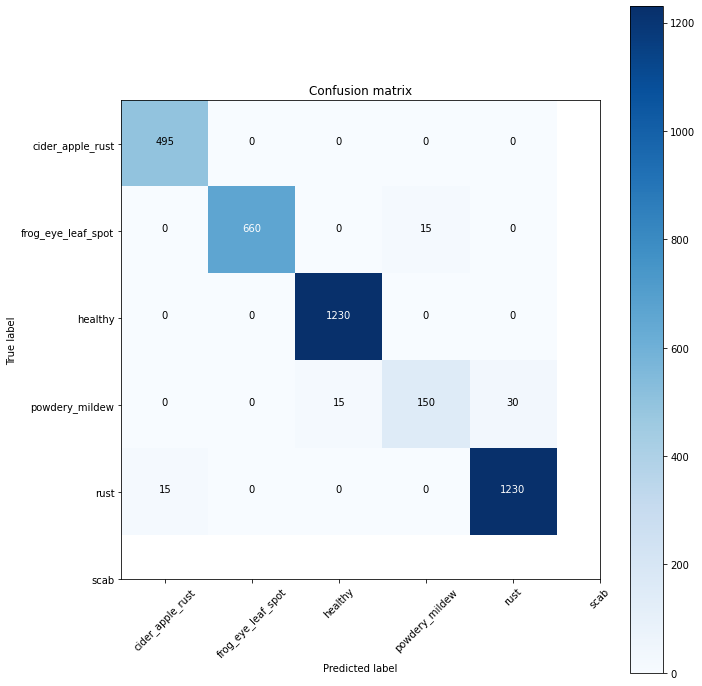

In [41]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, ['cider_apple_rust', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab'])


In [42]:
from sklearn.metrics import classification_report
print(classification_report(df['y_Predicted'],df['y_Actual']))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99       510
           1       0.98      1.00      0.99       660
           2       1.00      0.99      0.99      1245
           3       0.77      0.91      0.83       165
           4       0.99      0.98      0.98      1260

    accuracy                           0.98      3840
   macro avg       0.95      0.97      0.96      3840
weighted avg       0.98      0.98      0.98      3840



In [43]:
target=list(df['y_Predicted'].values)
labels_unique = sorted(set(target))
labels_lut = {lb: i for i, lb in enumerate(labels_unique)}
result=[]
def to_one_hot( labels:str) -> tuple:
        one_hot = [0] *len(labels_unique)
        one_hot[labels_lut[labels]]=1
        return (one_hot)
for i in target:
    result.append(to_one_hot(i))
pred_array=np.array(result)
pred_array.shape

(3840, 5)

In [44]:
target=list(df['y_Actual'].values)
labels_unique = sorted(set(target))
labels_lut = {lb: i for i, lb in enumerate(labels_unique)}
result=[]
def to_one_hot( labels:str) -> tuple:
        one_hot = [0] *len(labels_unique)
        one_hot[labels_lut[labels]]=1
        return (one_hot)
for i in target:
    result.append(to_one_hot(i))
act_array=np.array(result)
act_array.shape

(3840, 5)

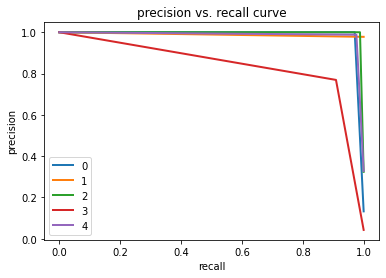

In [45]:
from sklearn.metrics import precision_recall_curve, roc_curve
# precision recall curve
precision = dict()
recall = dict()
for i in range(5):
    precision[i], recall[i], _ = precision_recall_curve(pred_array[:, i],
                                                        act_array[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='{}'.format([k for k,v in labels_lut.items()][i]))
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()